In [1]:
import numpy as np
import pandas as pd

# Load the dataset (replace 'data.csv' with your file path)
data = pd.read_csv('impedance_data_1.csv')
frequencies = data['Frequency']  # in Hz
Z_real_measured = data['Z_real']  # Real part of measured impedance
Z_imag_measured = data['Z_imag']  # Imaginary part of measured impedance


In [2]:
def impedance_model(frequencies, Rs, R, C):
    """
    Calculate real and imaginary components of impedance for given parameters.
    """
    omega = 2 * np.pi * frequencies  # Angular frequency
    Z_real = Rs + R / (1 + (omega * R * C)**2)
    Z_imag = -omega * R * C**2 / (1 + (omega * R * C)**2)
    return Z_real, Z_imag


In [3]:
def log_likelihood(params, frequencies, Z_real_measured, Z_imag_measured, sigma=1):
    """
    Compute the log-likelihood for the model.
    """
    Rs, R, C = params  # Unpack parameters
    Z_real_theory, Z_imag_theory = impedance_model(frequencies, Rs, R, C)
    
    # Calculate residuals
    delta_real = Z_real_measured - Z_real_theory
    delta_imag = Z_imag_measured - Z_imag_theory
    
    # Gaussian log-likelihood
    log_likelihood_real = -0.5 * np.sum((delta_real / sigma)**2)
    log_likelihood_imag = -0.5 * np.sum((delta_imag / sigma)**2)
    return log_likelihood_real + log_likelihood_imag


In [4]:
import emcee

# Define the prior bounds for parameters: [Rs, R, C]
def log_prior(params):
    Rs, R, C = params
    if 100 < Rs < 10000 and 100 < R < 10000 and 1e-8 < C < 1e-5:  # Example bounds
        return 0.0  # Uniform prior within bounds 0.0
    return -np.inf  # Log-probability of -inf outside bounds

# Define the full posterior (prior + likelihood)
def log_posterior(params, frequencies, Z_real_measured, Z_imag_measured):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, frequencies, Z_real_measured, Z_imag_measured)

# Set up MCMC
ndim = 3  # Number of parameters: Rs, R, C
nwalkers = 50  # Number of walkers
nsteps = 1000  # Number of steps
initial_guess = [1500, 1500, 1e-5]  # Initial guess for Rs, R, C (100, 100, 1e-6)

# Initialize walkers around the initial guess
p0 = [initial_guess + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

# Run the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior,
    args=(frequencies, Z_real_measured, Z_imag_measured)
)
sampler.run_mcmc(p0, nsteps, progress=True)

# Extract samples
samples = sampler.get_chain(flat=True)


  0%|          | 0/1000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:09<00:00, 109.12it/s]


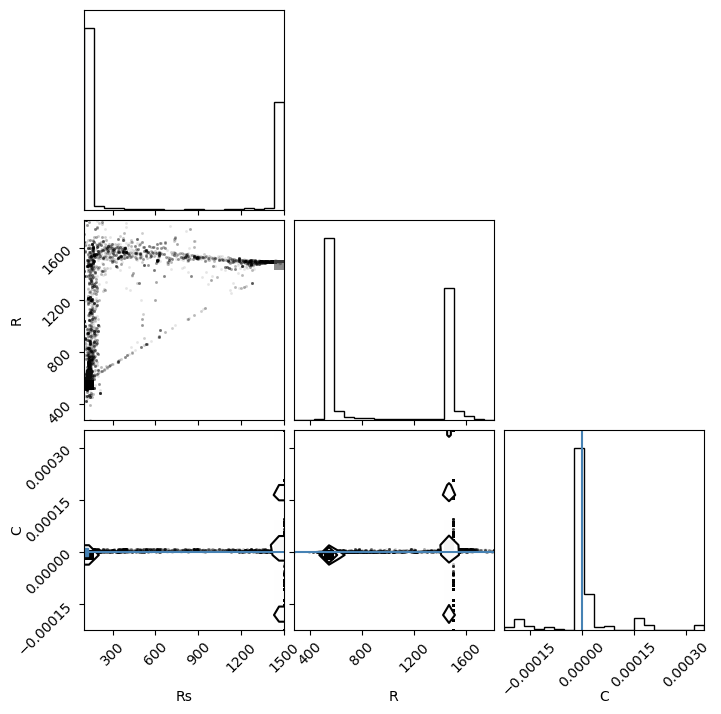

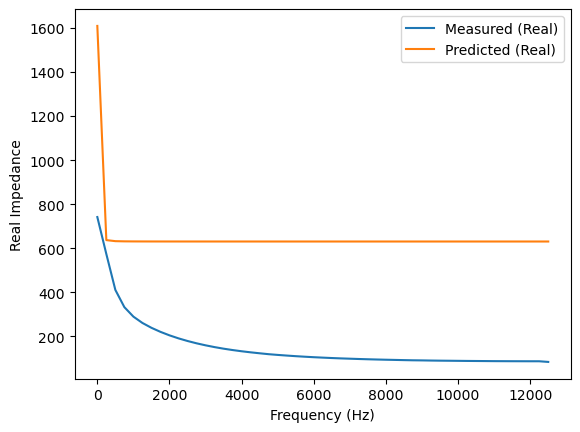

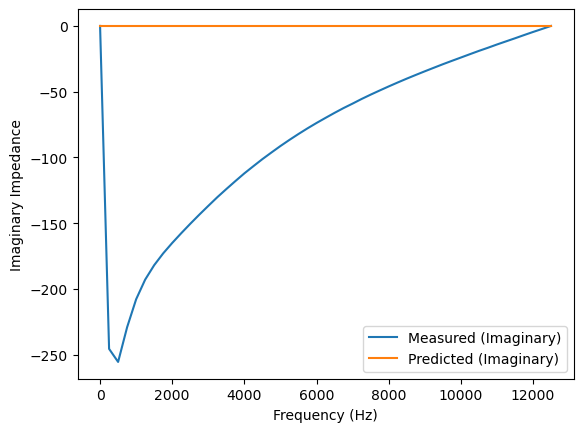

In [5]:
import matplotlib.pyplot as plt

# Plot the posterior distributions of parameters
import corner
corner.corner(samples, labels=["Rs", "R", "C"], truths=[100, 100, 1e-6])
plt.show()

# Predict using the best-fit parameters
best_fit_params = np.mean(samples, axis=0)
Z_real_pred, Z_imag_pred = impedance_model(frequencies, *best_fit_params)

# Compare predicted vs measured
plt.figure()
plt.plot(frequencies, Z_real_measured, label="Measured (Real)")
plt.plot(frequencies, Z_real_pred, label="Predicted (Real)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Real Impedance")
plt.legend()
plt.show()

plt.figure()
plt.plot(frequencies, Z_imag_measured, label="Measured (Imaginary)")
plt.plot(frequencies, Z_imag_pred, label="Predicted (Imaginary)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Imaginary Impedance")
plt.legend()
plt.show()


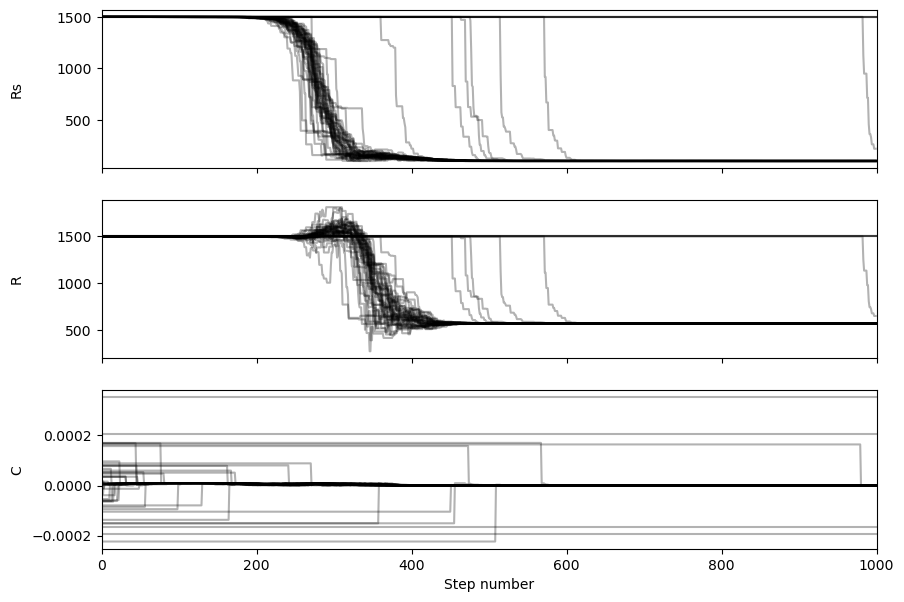

In [6]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = ["Rs", "R", "C"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number")
plt.show()

In [7]:
acceptance_rate_percentage = np.mean(sampler.acceptance_fraction) * 100
print(f"Acceptance rate: {acceptance_rate_percentage:.2f}%")

Acceptance rate: 35.37%
